In [52]:
import xbeamfit
import numpy as np 
from matplotlib import pyplot as plt 
import pandas as pd 
from datetime import datetime 
import scipy as sp
from scipy.integrate import trapz

import scipy.stats
from scipy.optimize import curve_fit


In [164]:
sigmas

array([[28.01810295, 28.01810295, 28.01810295, ..., 28.01810295,
        28.01810295, 28.01810295],
       [28.01810295, 28.01810295, 28.01810295, ..., 28.01810295,
        28.01810295, 28.01810295],
       [28.01810295, 28.01810295, 28.01810295, ..., 28.01810295,
        28.01810295, 28.01810295],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [53]:
def read_file(file_path, logger):
    """Loads data from file"""
    import numpy as np
    from pathlib import Path

    error_flag = False
    fid = open(file_path, 'r')
    if fid == -1:
        errstr = 'Cannot open the file: ' + file_path
        print(errstr)
        error_flag = True
    else:
        # Read header
        from_scope = {'delta_t_traces': '---', 'first_trigger': '---', 'tr_offset': []}
        for header_long, line in enumerate(fid):
            aux = line.split('* Date:  ')
            if len(aux) != 1:
                aux = aux[1]
                aux = aux.rstrip("\n")
                from_scope['date'] = aux

            aux = line.split('* Time:  ')
            if len(aux) != 1:
                aux = aux[1]
                aux = aux.rstrip("\n")
                from_scope['time'] = aux

            aux = line.split('* Time between traces:  ')
            if len(aux) != 1:
                aux = aux[1]
                aux = aux.rstrip("\n")
                if aux == '---':
                    continue
                from_scope['delta_t_traces'] = int(aux[0])

            aux = line.split('* First trigger:  ')
            if len(aux) != 1:
                aux = aux[1]
                aux = aux.rstrip("\n")
                if aux == '---':
                    continue
                from_scope['first_trigger'] = float(aux[0])

            aux = line.split('* Time interval per data point (sec):  ')
            if len(aux) != 1:
                aux = aux[1]
                from_scope['delta_t_pts'] = float(aux)

            aux = line.split('* Horizontal fastframe length:  ')
            if len(aux) != 1:
                aux = aux[1]
                from_scope['h_frame_length'] = int(aux)

            aux = line.split('* Number of frames:  ')
            if len(aux) != 1:
                aux = aux[1]
                n_frames = int(aux)
                from_scope['n_frames'] = n_frames

            aux = line.split('* Number of data points:  ')
            if len(aux) != 1:
                aux = aux[1]
                from_scope['n_data_pts'] = int(aux)

            aux = line.split('* Acquire mode:  ')
            if len(aux) != 1:
                aux = aux[1]
                aux = aux.rstrip("\n")
                from_scope['acq_mode'] = aux

            aux = line.split('* Filter:  ')
            if len(aux) != 1:
                aux = aux[1]
                aux = aux.rstrip("\n")
                from_scope['filter'] = aux

            aux = line.split('* Trigger holdoff time:  ')
            if len(aux) != 1:
                aux = aux[1]
                aux = aux.rstrip("\n")
                from_scope['tr_hold_off'] = aux

            aux = line.split('* Vertical scale (V/div):  ')
            if len(aux) != 1:
                aux = aux[1]
                from_scope['v_scale'] = float(aux)

            aux = line.split('* Vertical position (div):  ')
            if len(aux) != 1:
                aux = aux[1]
                from_scope['v_pos'] = float(aux)

            aux = line.split('* Input coupling:  ')
            if len(aux) != 1:
                aux = aux[1]
                aux = aux.rstrip("\n")
                from_scope['in_coupl'] = aux

            aux = line.split('* Input impedance:  ')
            if len(aux) != 1:
                aux = aux[1]
                aux = aux.rstrip("\n")
                from_scope['in_imp'] = aux

            aux = line.split('* Vertical bandwidth:  ')
            if len(aux) != 1:
                aux = aux[1]
                from_scope['v_bandwidth'] = float(aux)

            aux = line.split('* Scale Factor (dB):  ')
            if len(aux) != 1:
                aux = aux[1]
                from_scope['att_db'] = float(aux)

            aux = line.split('* Trigger offset (index sec):  ')
            if len(aux) != 1:
                aux = aux[1]
                aux = aux.split()
                from_scope['tr_offset'].append(float(aux[1]))
                header_end = header_long
                if len(from_scope['tr_offset']) == from_scope['n_frames']:
                    break
        fid.close()
        from_scope['tr_offset'] = np.array(from_scope['tr_offset'])

        # Read both numpy and ascii files
        if Path(file_path[:-3] + 'npy').exists():
            data = np.load(file_path[:-3] + 'npy')
        else:
            data = pd.read_csv(file_path, skiprows=header_end + 2, header=None)
            # This is for some old files where the zeros were not loaded properly
            data.replace({'0.000E+': '0'}, inplace=True)
            data = data.iloc[:, 0].astype(float)
            data = data.to_numpy()

        from_scope['acquired'] = np.reshape(data, (int(from_scope['h_frame_length']),
                                                    int(from_scope['n_frames'])), order='F')

        #if not error_flag:
        #    from_scope = Acquisition.add_timescale(from_scope, logger)

    return from_scope





def calculate_intensity(aux, lower, upper, plot=True):
    total_intensity = []
    for i in range(aux['n_frames']):
        total_intensity.append(trapz(aux['acquired'][lower:upper,i])) # only the first batch 
    if plot==True:
        plt.plot(total_intensity, label='Total Intensity all bunches in batch 1')
        plt.grid()
        plt.ylabel('Intensity')
        plt.legend()
        plt.xlabel('ms')
        plt.tight_layout()
        plt.show()
    return total_intensity 


def flat_values(data, thresh):
    data_flat = np.zeros(data.size)
    for i in np.arange(data.size):
        if  data[i] < thresh:
            data_flat[i] = 0
        else: 
            data_flat[i] = data[i]
    return data_flat

def calculate_intensity_flat(flat,lower, upper, plot=True):
    total_intensity = []
    total_intensity.append(np.sum(flat[lower:upper])) # only the first batch 
    
    if plot==True:
        plt.plot(total_intensity, label='Total Intensity all bunches in batch 1')
        plt.grid()
        plt.ylabel('Intensity')
        plt.legend()
        plt.xlabel('ms')
        plt.tight_layout()
        plt.show()
    return total_intensity 

In [54]:

delays = pd.read_parquet('/home/elamb/lsa_test/lumi-followup/examples/nx2pd/delays.parquet')
params = pd.read_parquet('/home/elamb/lsa_test/lumi-followup/examples/nx2pd/params.parquet')

In [55]:
aux=read_file('MD_135.asc', 'MD_135.npy')


flat0 = flat_values(aux['acquired'][0:51000,0], 0.003)
flatend = flat_values(aux['acquired'][0:51000,-1], 0.003)



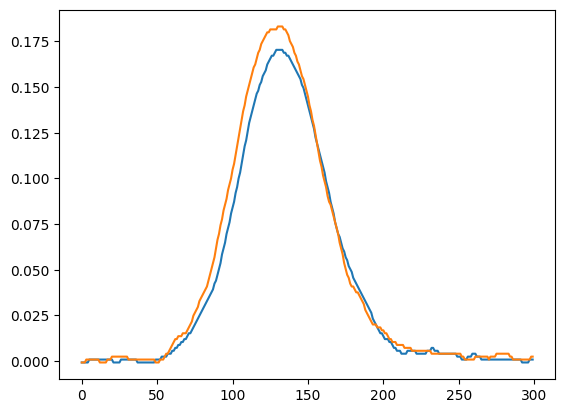

In [56]:
# every 1000 data points starting after 2500

# make a dataframe with 50 different bunches populating with dat a

plt.plot(aux['acquired'][2700:3000,0])
plt.plot(aux['acquired'][3700:4000,0])



In [133]:
        
bunch_intensity = {}
for i in range(48):
    datavalloop = aux['acquired'][2600+i*999:3000+i*999,5000]
    bunch_intensity[i] = datavalloop
    
        
        
noise = {}
for i in range(48):
    dataval = aux['acquired'][3000+i*999:3300+i*999,5000]
    noise[i] = dataval

#bunches = pd.DataFrame(dicts.items()) 


bunch_intensity = pd.DataFrame(bunch_intensity.items(), columns=['bunch number', 'intensity'])
noise = pd.DataFrame(noise.items(), columns=['bunch number', 'noise'])

#for i in range(48):
#    bunch_intensity['bunch number'][i] = i+1
 #noise['bunch number'][i] = i+1

noise['average'] = 0
bunch_intensity['corrected_intensity']  = 0
bunch_intensity['average_noise']  = 0

for i in range(48):
    noise['average'].iloc[i] = np.mean(noise['noise'].iloc[i])
    bunch_intensity['average_noise'].iloc[i]  = noise['average'].iloc[i]
    
    
    
correct_5000 = []
for i in range(48):
    correct_5000.append(bunch_intensity['intensity'].iloc[i] - bunch_intensity['average_noise'].iloc[i])
    
#for i in range(48):
#    bunch_intensity['corrected_intensity'].iloc[i]  = np.array(correct[i])
    

    
    

    

    
                                          
                                          


/tmp/ipykernel_2721760/1862298861.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  noise['average'].iloc[i] = np.mean(noise['noise'].iloc[i])
/tmp/ipykernel_2721760/1862298861.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bunch_intensity['average_noise'].iloc[i]  = noise['average'].iloc[i]


dtype('int64')

In [112]:
bunch length reduction factor 

dtype('float64')

In [61]:
bunch_intensity['']

bunch_intensity['bunch_length'] = bunch_intensity[']

,bunch number,intensity


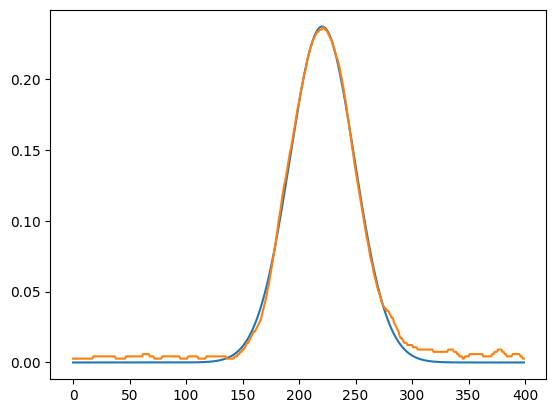

In [127]:


import xbeamfit as xb
#popt1,pcov1,popte1,x_gaussianfit1,y_gaussianfit1 = xbeamfit.fitting.makeGaussianFit(np.linspace(0,300),bunch1, -10)
def makeGaussianFit(X,Y,Y_threshold):
    
    X=np.array(X); Y=np.array(Y)
    i = np.where(Y>Y_threshold)
    X=X[i].astype(float); Y=Y[i].astype(float)
    
    # guessing initial fit parameters to converge faster
    mean = xb.statistics.findMean(X,Y)
    sigma = xb.statistics.findSigma(X,Y)[0]

    popt,pcov = curve_fit(xbeamfit.distributions.Gaussian, X, Y, p0=[np.max(Y), mean, sigma])
    popte = np.sqrt(np.diag(pcov))
    x_gaussianfit = np.linspace(min(X), max(X), 1000)
    y_gaussianfit = xb.distributions.Gaussian(x_gaussianfit, *popt)
    
    return popt,pcov,popte,x_gaussianfit,y_gaussianfit


x_data = np.arange(0,400)

popt0,pcov,popte,x_gaussianfit,y_gaussianfit = makeGaussianFit(np.arange(0,400), correct_0[n_bunch],-100)
plt.plot(x_gaussianfit, y_gaussianfit)
plt.plot(x_data, correct_0[10])

[ 16.48727096 221.24967687  30.1473657 ] [ 15.26121331 222.200352    29.27037302] bunch number 9
longitudinal sigma changed by  -2.909019278495336


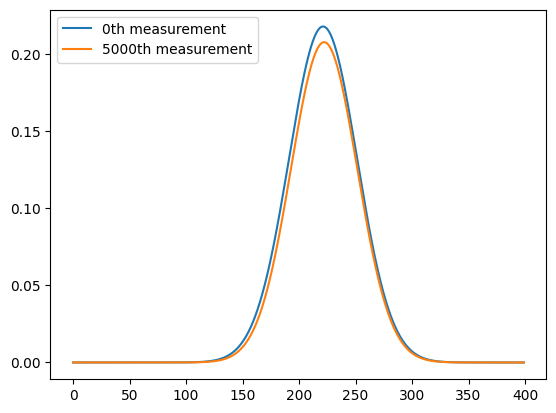

In [146]:
# you can show how the sigma of each of the profiles reduces overtime for each bunch... 

n_bunch = 9

popt0,pcov,popte,x_gaussianfit,y_gaussianfit = makeGaussianFit(np.arange(0,400), correct_0[n_bunch],-100)
popt1,pcov,popte,x_gaussianfit1,y_gaussianfit1 = makeGaussianFit(np.arange(0,400), correct_5000[n_bunch],-100)
plt.plot(x_gaussianfit, y_gaussianfit, label='0th measurement')
plt.plot(x_gaussianfit1, y_gaussianfit1, label='5000th measurement')
plt.legend()


# what is the difference in bunch length here... ? 

print(popt0, popt1, 'bunch number', n_bunch)
print('longitudinal sigma changed by ', popt1[2]/popt0[2]*100-100)

Text(0, 0.5, 'bunch length')

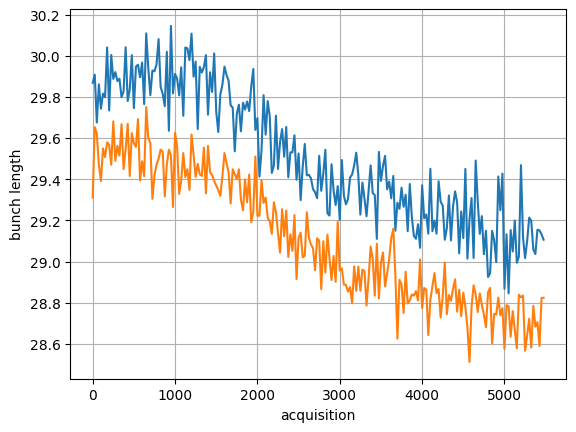

In [244]:
# for each bunch can take the average of the noisy period and add it to the total of the bunch... 

# then find a gaussian fit and integrate the total to give an intensity of the bunch up to 10 sigma 

x = np.arange(points)*sample_acq
for i in np.arange(0,10,5):
    plt.plot(x, sigmas33[:,i])
plt.grid()
plt.xlabel('acquisition')
plt.ylabel('bunch length')

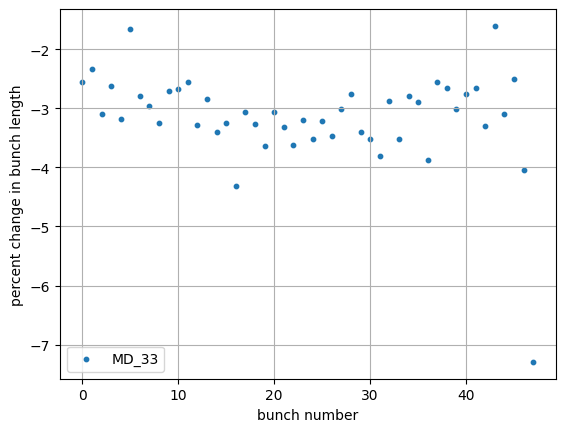

In [243]:
reduction35 = np.zeros(48)
for i in range(48):
    reduction35[i] = sigmas[-1,i]/sigmas[0,i]*100-100
#plt.scatter(range(0,48),reduction35, label='MD_35', s=10)

reduction33 = np.zeros(48)
for i in range(48):
    reduction33[i] = sigmas33[-1,i]/sigmas33[0,i]*100-100
    
error_r_33 = np.zeros(48)
for i in range(48):
    error_r_33[i] = (error33[-1,i]/sigmas33[-1,i] + error33[0,i]/sigmas33[0,i])*reduction33[i]
    

plt.scatter(range(0,48),reduction33, label='MD_33', s=10)
    
plt.grid()
plt.ylabel('percent change in bunch length')
plt.xlabel('bunch number')
plt.legend()


array([-0.01555629, -0.01540131, -0.02032883, -0.01755443, -0.02273827,
       -0.01215455, -0.02032245, -0.02313401, -0.02423135, -0.02060404,
       -0.01895359, -0.01923143, -0.02275372, -0.02087348, -0.02606166,
       -0.02288679, -0.03006312, -0.02375955, -0.02430715, -0.02402369,
       -0.02444296, -0.02398014, -0.02597465, -0.02292798, -0.02690828,
       -0.02417568, -0.0265658 , -0.02280944, -0.01956205, -0.02529304,
       -0.02340379, -0.0284262 , -0.02216417, -0.02708935, -0.02159793,
       -0.02286359, -0.02988917, -0.02112354, -0.02026042, -0.02261762,
       -0.02215886, -0.02217397, -0.02619773, -0.01330968, -0.02508733,
       -0.02102461, -0.03453785, -0.06909978])

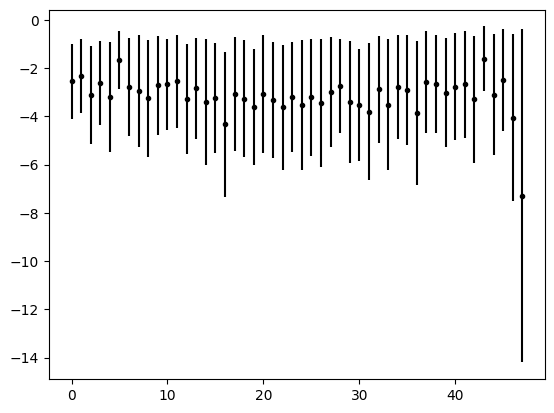

In [230]:
plt.errorbar(range(0,48), reduction33, yerr=error_r_33*100, xerr=None,fmt='.k')


In [209]:
popte

array([0.05325211, 0.13298254, 0.13298254])

In [241]:
### first load the file 

aux=read_file('MD_123.asc', 'MD_123.npy')

# just to get the lengths

sample_acq = 100
points = 55
sigmas33 = np.zeros([points,48]) # populate a numpy array with the sigmas 
error33 = np.zeros([points,48])
for k in range(points):
    bunch_intensity = {}
    for i in range(48):
        datavalloop = aux['acquired'][2600+i*999:3000+i*999,sample_acq*k]
        bunch_intensity[i] = datavalloop


    noise = {}
    for i in range(48):
        dataval = aux['acquired'][3000+i*999:3300+i*999,sample_acq*k]
        noise[i] = dataval

    #bunches = pd.DataFrame(dicts.items()) 


    bunch_intensity = pd.DataFrame(bunch_intensity.items(), columns=['bunch number', 'intensity'])
    noise = pd.DataFrame(noise.items(), columns=['bunch number', 'noise'])



    noise['average'] = 0
    bunch_intensity['corrected_intensity']  = 0
    bunch_intensity['average_noise']  = 0

    for i in range(48):
        noise['average'].iloc[i] = np.mean(noise['noise'].iloc[i])
        bunch_intensity['average_noise'].iloc[i]  = noise['average'].iloc[i]
        
        
    corrected_intensity = []
    for i in range(48):
        corrected_intensity.append(bunch_intensity['intensity'].iloc[i] - bunch_intensity['average_noise'].iloc[i])
    
    
    
    
    sigma_turn_n = np.zeros(48)
    error_turn_n = np.zeros(48)

    for i in range(48):
        popt0,pcov,popte,x_gaussianfit,y_gaussianfit = makeGaussianFit(np.arange(0,400), corrected_intensity[i],-100)

        
        sigma_turn_n[i] = popt0[2] # append the sigma 
        error_turn_n[i] = popte[2] # append the error 

    
    sigmas33[k,:] = sigma_turn_n; 
    error33[k,:] = error_turn_n; 

    
    

ValueError: cannot reshape array of size 335296496 into shape (390000000,)

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

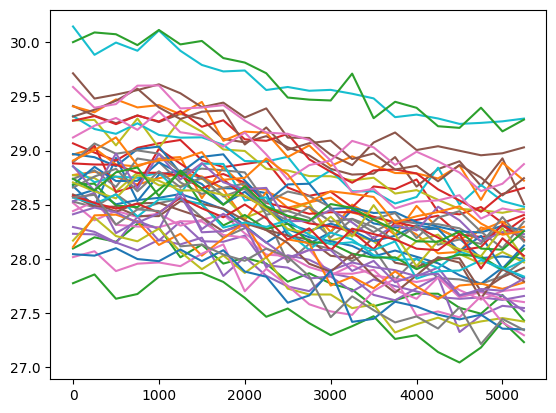